# Estimating object location from noisy radar echos

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
# mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Material from lecture 2

import packages:
- multivariate normal distribution
- inverse of a matrix from linear algebra

auxiliary function takes the axes and parameters of a 2-dimensional normal distribution + graph title, figure title, locations of points from which this distribution was estimated
(connects points of the same probability density)


Task.

Radar at an airport sends out radio waves, they bounce off objects, we get a reflection --> we are supposed to locate the object. The object is not moving. [We do not use the Calman filter --> relax].
The radar returns a plane [-10;10] and somewhere there the object is located. The measurements of the reflected waves are with some error. The error is pretty well approximated by a normal distribution - the manufacturer has given us the covariance matrix of this radar (we have it).
We are going to get this echo and we want to find out where our object is.
We generate true_x - the true location of the object, but we don't handle it.

Echo - multivariate normal distribution - expected value - where the radar is, stanard deviation - single measurement error.

From the echo measurement we estimate the probability distribution of where our object may be + uncertainty based on the measurement

Most objects are located in a sphere of radius 3, centred on the radar plane (we know this from our experience of working at the airport)

## Useful imports

In [3]:
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv

## Useful utility functions

In [4]:
# Plot 'iso-densities' for MVN
#   ax - axis for plotting,
#   mu, Sigma - MVN parameters,
#   observations - observations (data points) to mark on the plot,
#   title - plot title.
def plot_mvn(ax, mu, Sigma, observations = None, title = None,
             xmin=-10, xmax=10, ymin=-10, ymax=10, grid_size = 100):
    X = np.linspace(xmin, xmax, grid_size)
    Y = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(X, Y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T
    
    p = mvn(mu, Sigma)
    density = p.pdf(grid).reshape((grid_size, grid_size))

    ax.contour(X, Y, density, zorder=1)
    
    if observations is not None:
        if len(observations.shape) == 1:
            ox, oy = observations[0], observations[1]
        else:
            ox, oy = observations[:, 0], observations[:, 1]
            
        ax.scatter(ox, oy, s=100, c='r', marker='x', zorder=2)
    
    if title is not None:
        ax.set_title(title)
    
    ax.axis('equal')
    plt.show

## Estimating object location from (one) noisy radar echo

Our task is to estimate location of a stationary object from its radar echo.

Assumptions:
- radar plane is a $[-10, 10] \times [-10, 10]$ rectangle,
- radar echo gives us a noisy measurement of the true location,
- the measurement noise is well modeled by a multivariate Gaussian with precision: `radar_echo_Prec`.

In [5]:
radar_echo_Sigma = np.array([[2, -1.5],
                             [-1.5, 2]]) # E_y

radar_echo_Prec = inv(radar_echo_Sigma) # E_y^(-1)

For now, we have only one radar echo to work with. It is stored in: `radar_echo`.

In the code below, `true_x` is the true location of the object on the radar plane. We imagine that we do not know this location (our task is to estimate it).

In [6]:
true_x = np.array([5.0, 5.0])

radar_echo = mvn.rvs(true_x, radar_echo_Sigma, size=1, random_state=1234) # y

---

Propose (and be ready to justify) a probabilistic model for estimating object location from the radar echo. This model must:
1. estimate a likely location of the object,
1. estimate uncertainty in the (estimated) object location.

From working experience with our radar we know that objects are most often located in a sphere with radius $r=3$ centered in the radar plane.

---

Implement the proposed model in `estimate_location_from_echo` function. The arguments to this function should be:
- radar echo,
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo` should return parameters of the probability distribution that expresses our beliefs about object location after observing one radar echo.

### Model proposition

We are given all the data connected with `y` i.e `radar_echo`, `radar_echo_Sigma`, `radar_echo_Prec`.

Using the knowledge from the lecture we can write:

$$\Sigma_{\mathbf{x}|\mathbf{y}} = \left[ \Sigma_{\mathbf{x}}^{-1} + \mathbf{A}^{\top} \Sigma_{\mathbf{y}}^{-1} \mathbf{A} \right]^{-1}$$

$$\boldsymbol{\mu}_{\mathbf{x}|\mathbf{y}} = \Sigma_{\mathbf{x}|\mathbf{y}} \left[ \mathbf{A}^{\top} \Sigma_{\mathbf{y}}^{-1} (\mathbf{y} - \mathbf{b}) + \Sigma_{\mathbf{x}}^{-1} \boldsymbol{\mu}_{\mathbf{x}} \right]$$

Now we have to estimate *a priori* information:
- $\Sigma_{\mathbf{x}}$
- ${\mu}_{\mathbf{x}}$

We know that objects are most often located in a sphere with radius $r=3$ and the radar plane is a $[-10, 10] \times [-10, 10]$ rectangle.

$\Sigma_{\mathbf{x}}$ $\rightarrow$ errors are independent for different dimensions $\rightarrow$ we can use a diagonal covariance matrix

$$\Sigma_{\mathbf{x}} = \begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 \end{bmatrix}$$



<div style="max-width:500px; margin: 0 auto; text-align: center;">
    
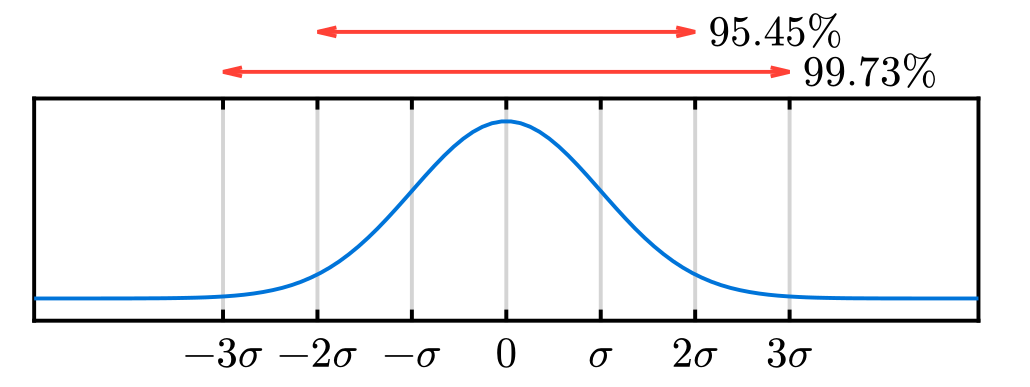
    
</div>

Using 95% rule, we can assume that $2\sigma = 3$, then $\sigma = 1.5$ and $\sigma^2 = 2.25$. That gives us the following covariance matrix:

$$\Sigma_{\mathbf{x}} = \begin{bmatrix} 2.25 & 0 \\ 0 & 2.25 \end{bmatrix}$$

Based on the center of the sphere with radius $r=3$:
$$\mu_{\mathbf{x}} = (0, 0)$$

-----------

$$\mathbf{y} = \mathbf{A} \mathbf{x} + \mathbf{b} + \boldsymbol{\epsilon}$$
$$\boldsymbol{\epsilon} \sim \mathcal{N} \left( \mathbf{0}, \Sigma_{\mathbf{y}} \right)$$

Knowing that our measurement device is very accurate, we can assume that:
- there are no transformations or rotations of the function, so our matrix $\mathbf{A} = \mathbf{I}$ (identity matrix),
- there is no systematic bias, so $\mathbf{b} = \mathbf{0}$ (zero vector).

Thus, our equations finally look like that:

$$\Sigma_{\mathbf{x}|\mathbf{y}} = \left[ \Sigma_{\mathbf{x}}^{-1} + \Sigma_{\mathbf{y}}^{-1} \right]^{-1}$$
$$\boldsymbol{\mu}_{\mathbf{x}|\mathbf{y}} = \Sigma_{\mathbf{x}|\mathbf{y}} \left[ \Sigma_{\mathbf{y}}^{-1} \mathbf{y} + \Sigma_{\mathbf{x}}^{-1} \boldsymbol{\mu}_{\mathbf{x}} \right]$$

In [7]:
# raise Exception('Implement estimate_location_from_echo function and define all needed global variables')

# The function takes whatever we want, e.g. a priori assumptions
# Most objects are in a sphere of radius 3, centred on the radar plane (we know this from our work at the airport)
# measurements

# function should return estimated parameters of measurement over position
# propose model, justify, implement
# ------------------------------------------------------------------------

# prior assumptions about x (a priori)
sigma_x = np.array([
    [2.25, 0],
    [0, 2.25]
])

mu_x = np.array([0, 0])

# A = I (singular matrix) -> no scaling or rotation
# B = [0, 0] -> there is no bias

def estimate_location_from_echo(radar_echo, radar_echo_Prec, sigma_x, mu_x):
    '''
    return: (mu_xy, sigma_xy)
    '''
    inv_sigma_x = inv(sigma_x)
    sigma_xy = inv(inv_sigma_x + radar_echo_Prec)

    mu_xy = sigma_xy @ (radar_echo_Prec @ radar_echo + inv_sigma_x @ mu_x)

    return mu_xy, sigma_xy

Now, use `estimate_location_from_echo` to estimate object location (and uncertainty). Then use `plot_mvn` function to plot two 'iso-density' plots:
- one for our prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include location of the radar echo.

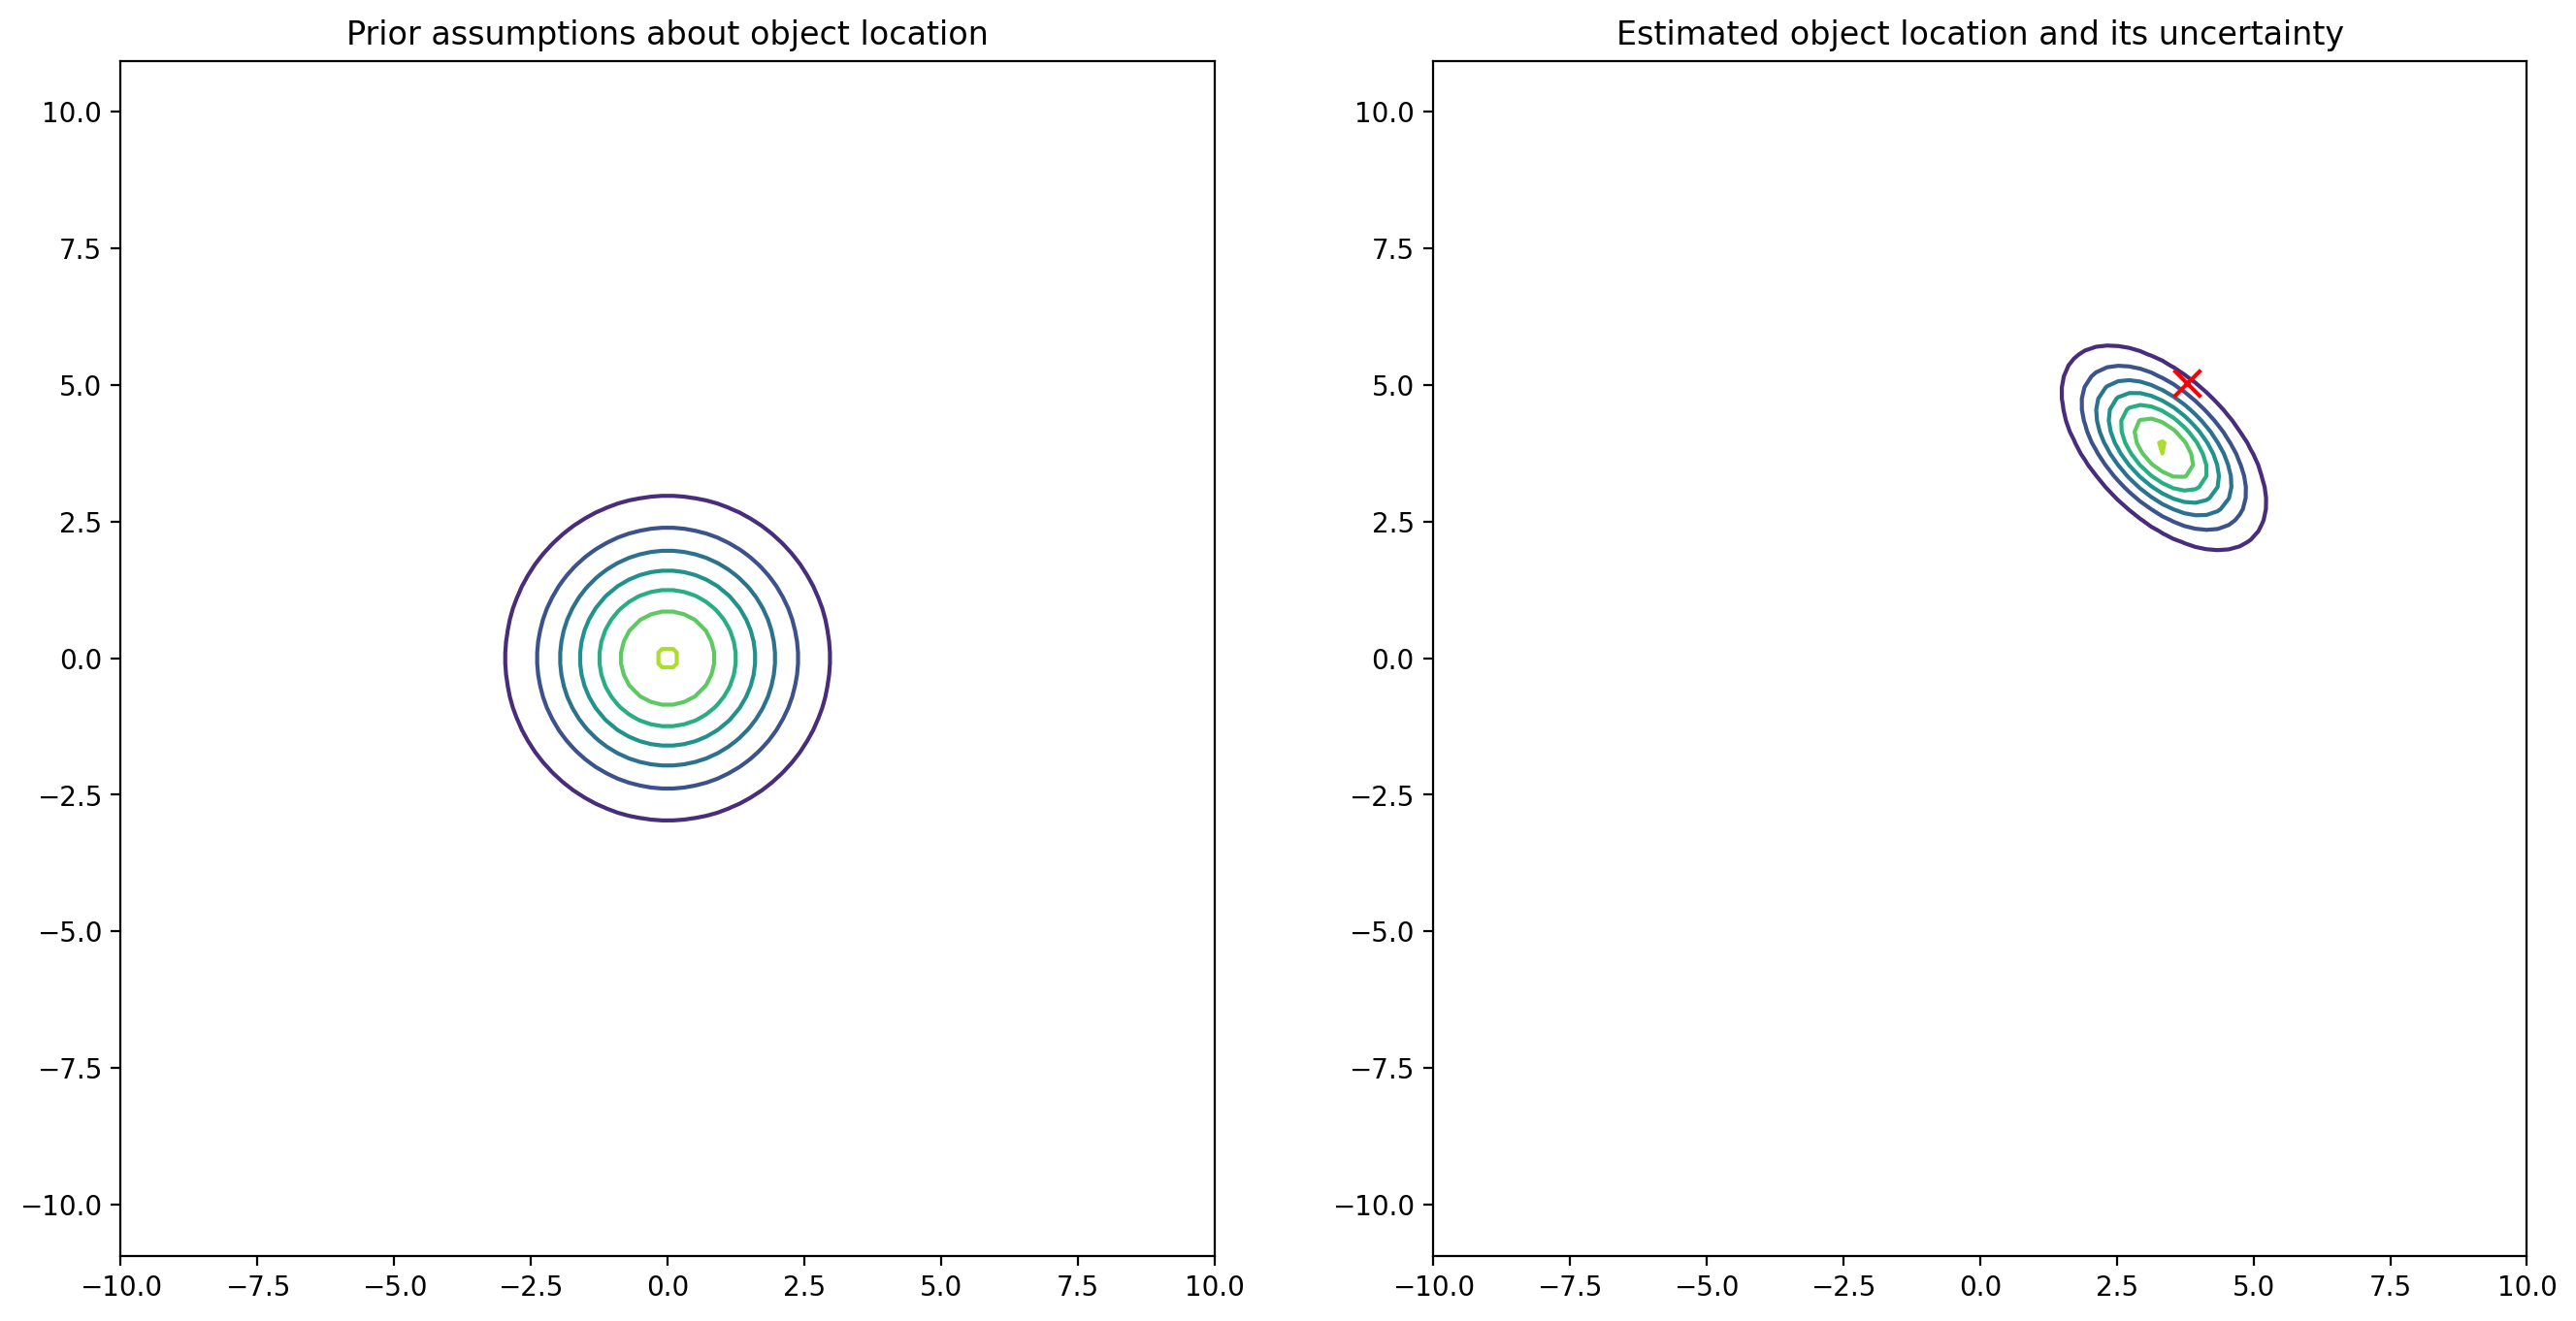

In [8]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

# raise Exception('Estimate object location and plot the requested iso-density plots')

mu_xy, sigma_xy = estimate_location_from_echo(radar_echo, radar_echo_Prec, sigma_x, mu_x)

plot_mvn(ax[0], mu_x, sigma_x, None, "Prior assumptions about object location")
plot_mvn(ax[1], mu_xy, sigma_xy, radar_echo, "Estimated object location and its uncertainty")

### Mikrozadanko

Zmienić coś w warunkach tego zadania, aby posterior był skośny w przeciwną stronę (i nie chodzi o modyfikację wykresu)

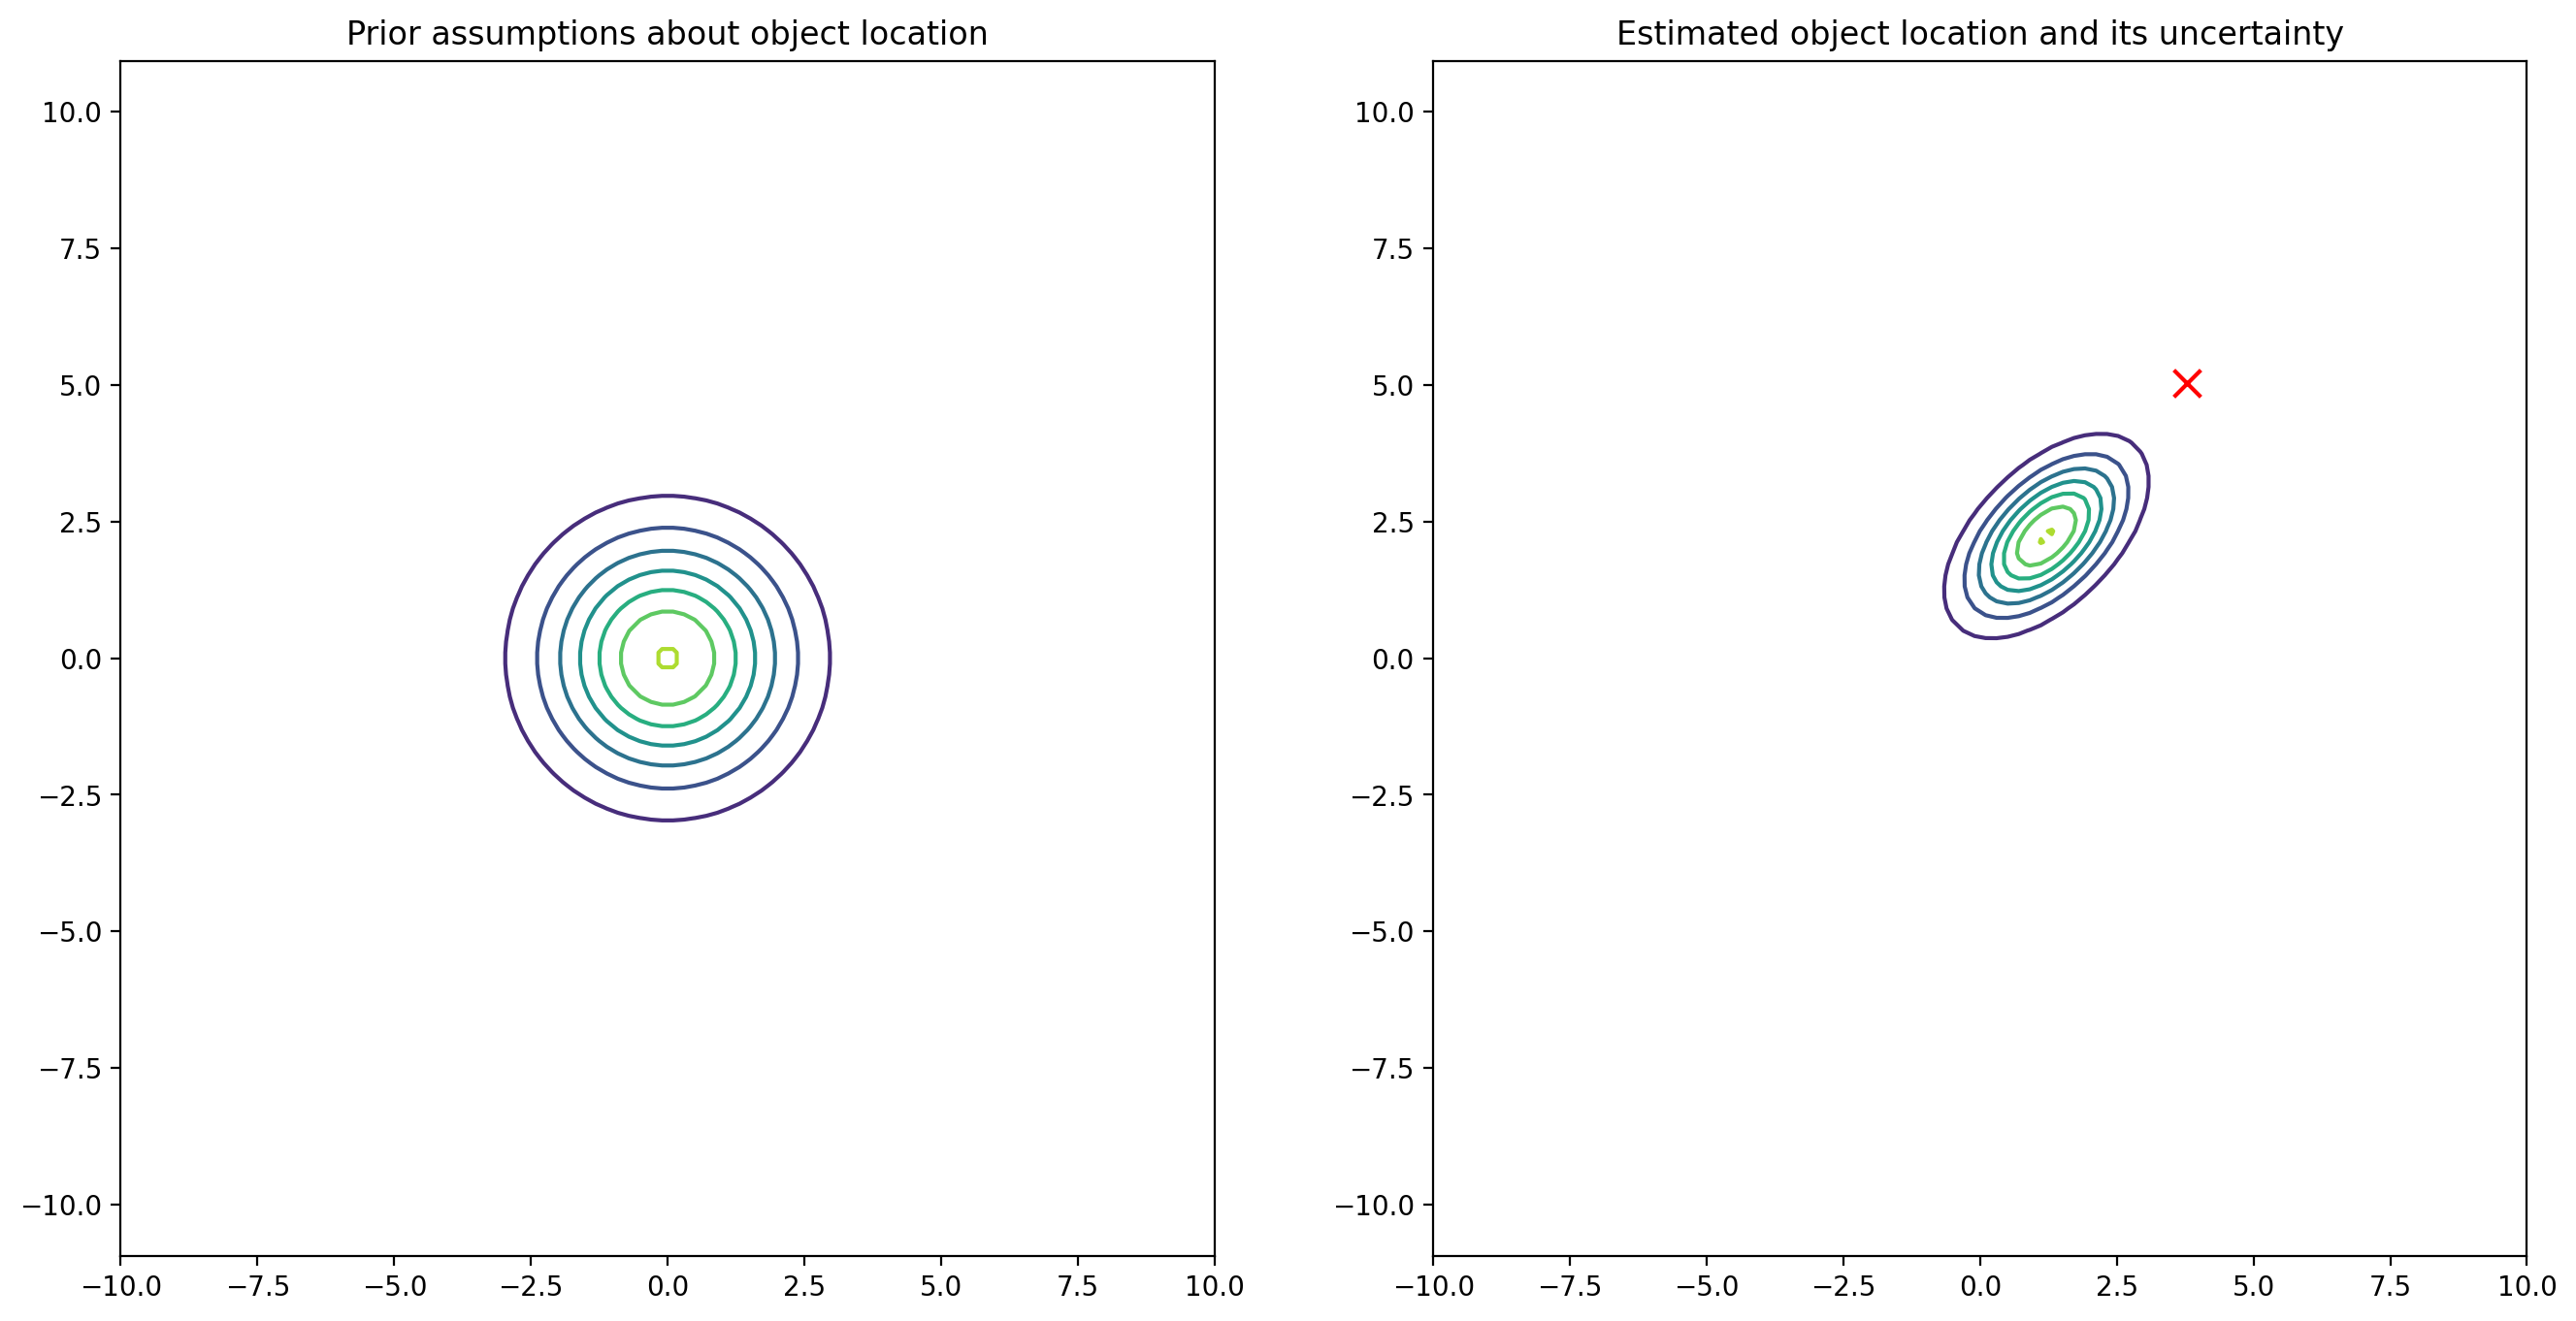

In [25]:
# radar_echo_Sigma = np.array([[2, -1.5],
#                              [-1.5, 2]]) # E_y


radar_echo_Sigma2 = np.array([[2, 1.5],
                             [1.5, 2]]) # E_y

radar_echo_Prec2 = inv(radar_echo_Sigma2) # E_y^(-1)

_, ax = plt.subplots(1, 2, figsize=(16,8))

mu_xy, sigma_xy = estimate_location_from_echo(radar_echo, radar_echo_Prec2, sigma_x, mu_x)

plot_mvn(ax[0], mu_x, sigma_x, None, "Prior assumptions about object location")
plot_mvn(ax[1], mu_xy, sigma_xy, radar_echo, "Estimated object location and its uncertainty")

## Estimating object location from multiple noisy radar echos

Now imagine that we have $N$ radar echos for a single object (we made $N$ independent radar scans). These echos are stored in `radar_echo_n`.

In [9]:
N = 5

radar_echo_n = mvn.rvs(true_x, radar_echo_Sigma, size=N, random_state=1234)

# we want to perform an iterative estimate -> the potential location is assumed as the basis for the next estimation,
# and so on for N iterations (the result of the function becomes the assumption for the next iteration)

Our goal is to estimate object location (and uncertainty) from all these radar scans. One simple option is to iteratively update our beliefs about object location as new echos arrive.

That is:
- we start with prior assumptions about object location,
- we update our beliefs about object location when we observe a radar echo,
- once we observe another radar echo, we can treat our current beliefs about object location (estimated above) as prior assumptions,
- we can continue in this iterative manner until we accounted for evidence from all observed echos.

---

Implement the iterative procedure described above to estimate object location (and uncertainty) from all radar echos stored in `radar_echo_n`. Use `estimate_location_from_echo` function for updating beliefs about object location.

In [10]:
# raise Exception('Implement the iterative location/uncertainty update procedure described above')

def iterative_estimation(radar_echo_n, radar_echo_Prec, iter_mu_x, iter_sigma_x):
    for i in range(N):
        iter_mu_x, iter_sigma_x = estimate_location_from_echo(radar_echo_n[i], radar_echo_Prec, iter_sigma_x, iter_mu_x)

    return iter_mu_x, iter_sigma_x

Use `plot_mvn` function to plot two 'iso-density' plots:
- one for prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include locations of all radar echos stored in `radar_echo_n`.

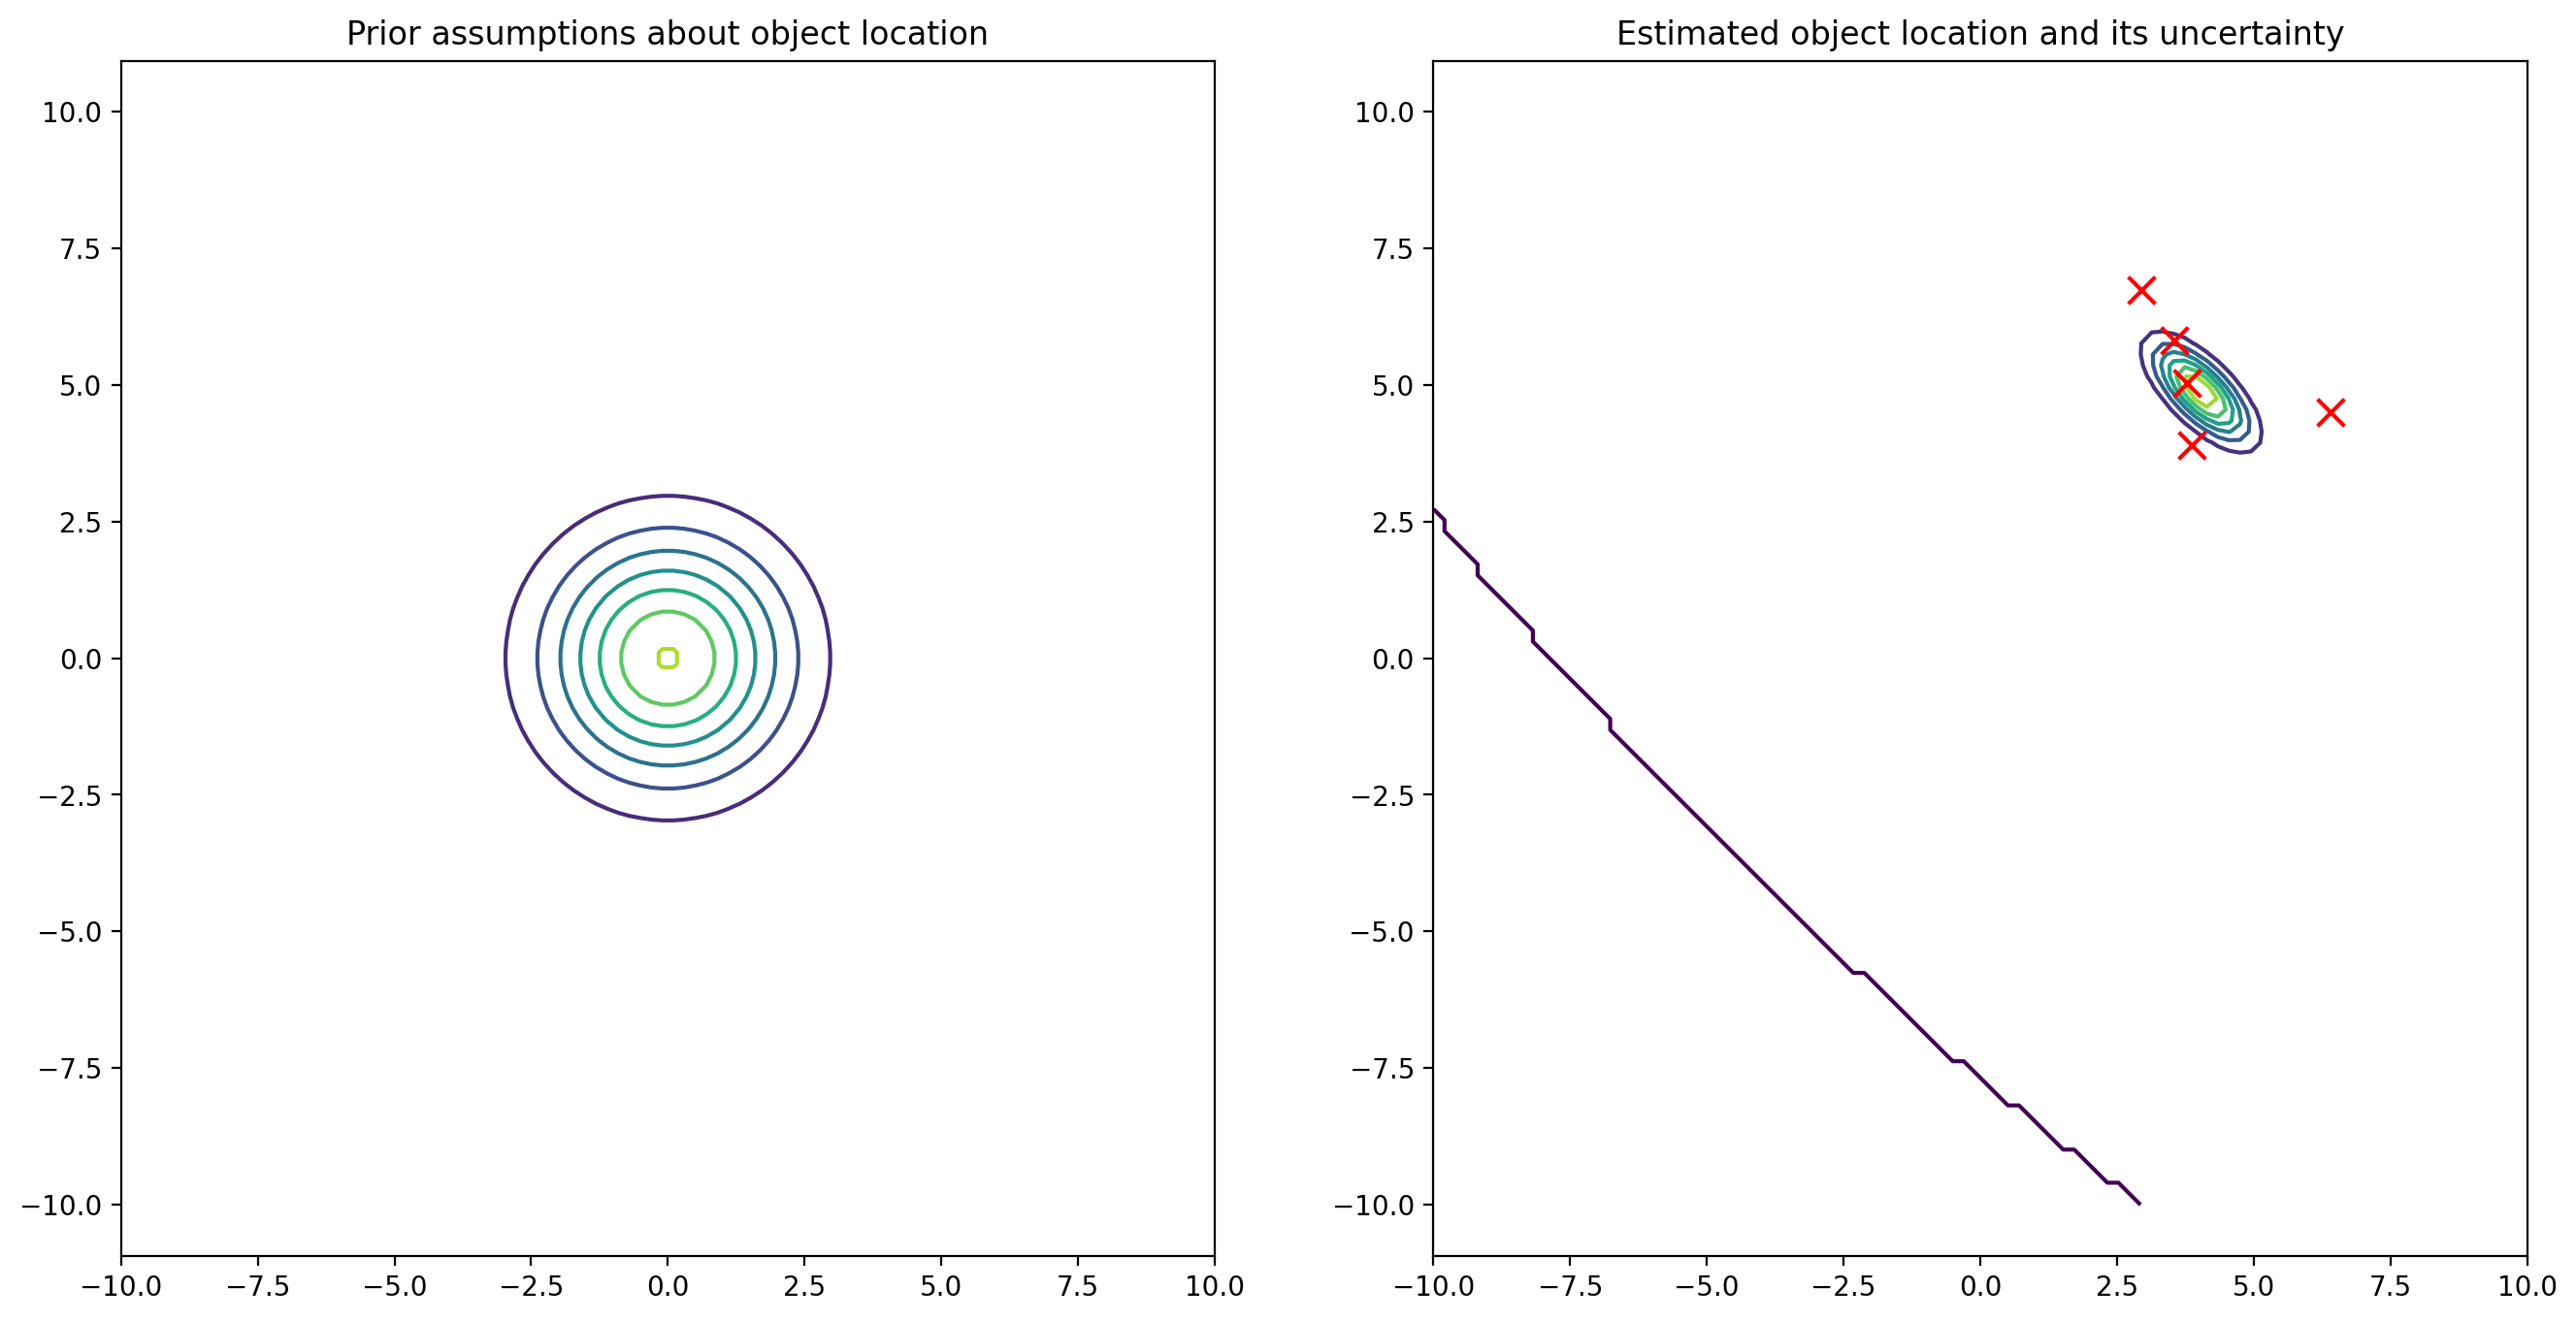

In [11]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

# raise Exception('Plot the requested iso-density plots')

mu_xy, sigma_xy = iterative_estimation(radar_echo_n, radar_echo_Prec, mu_x, sigma_x)

plot_mvn(ax[0], mu_x, sigma_x, None, "Prior assumptions about object location")
plot_mvn(ax[1], mu_xy, sigma_xy, radar_echo_n, "Estimated object location and its uncertainty")

The iterative update procedure implemented above has one drawback - it's not efficient (computationally).

If you came up with a sensible probabilistic model it should be possible to derive equations for estimating object location (and uncertainty) from all radar echos (in a single pass). Try to write down these equations and implement them in `estimate_location_from_echo_batch` function. The arguments to this function should be:
- radar echos (in a NumPy array),
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo_batch` should return parameters of the probability distribution that expresses our beliefs about object location after observing all radar echos.

---

Hint: try to write down parameters of the probability distribution over object location after:
- observing one echo, e.g. $e_1$,
- then observing another echo, e.g. $e_2$.

Guess a form of the batch-update equations from these examples. Then prove by induction that it is correct.

In [12]:
# raise Exception('Implement estimate_location_from_echo_batch function')

# derive the equation for N measurements at once (not iteratively) on paper,
# proof of correctness e.g. by induction -> attach a scan below the entire code


# mu_x skipped, because multiplication by zero results in zero

def estimate_location_from_echo_batch(radar_echo_n, radar_echo_Prec, sigma_x):
    inv_sigma_x = inv(sigma_x)

    sigma_n = inv(inv_sigma_x + N * radar_echo_Prec)
    mu_n = sigma_n @ (radar_echo_Prec @ np.sum(radar_echo_n, axis = 0))

    return mu_n, sigma_n

Use `estimate_location_from_echo_batch` to estimate object location (and uncertainty) from all radar echos.

Next, use `plot_mvn` function to make 'iso-density' plots identical to the ones above, but using location and uncertainty estimates from `estimate_location_from_echo_batch`.

Verify that estimates from `estimate_location_from_echo_batch` agree with the ones from the iterative update procedure.

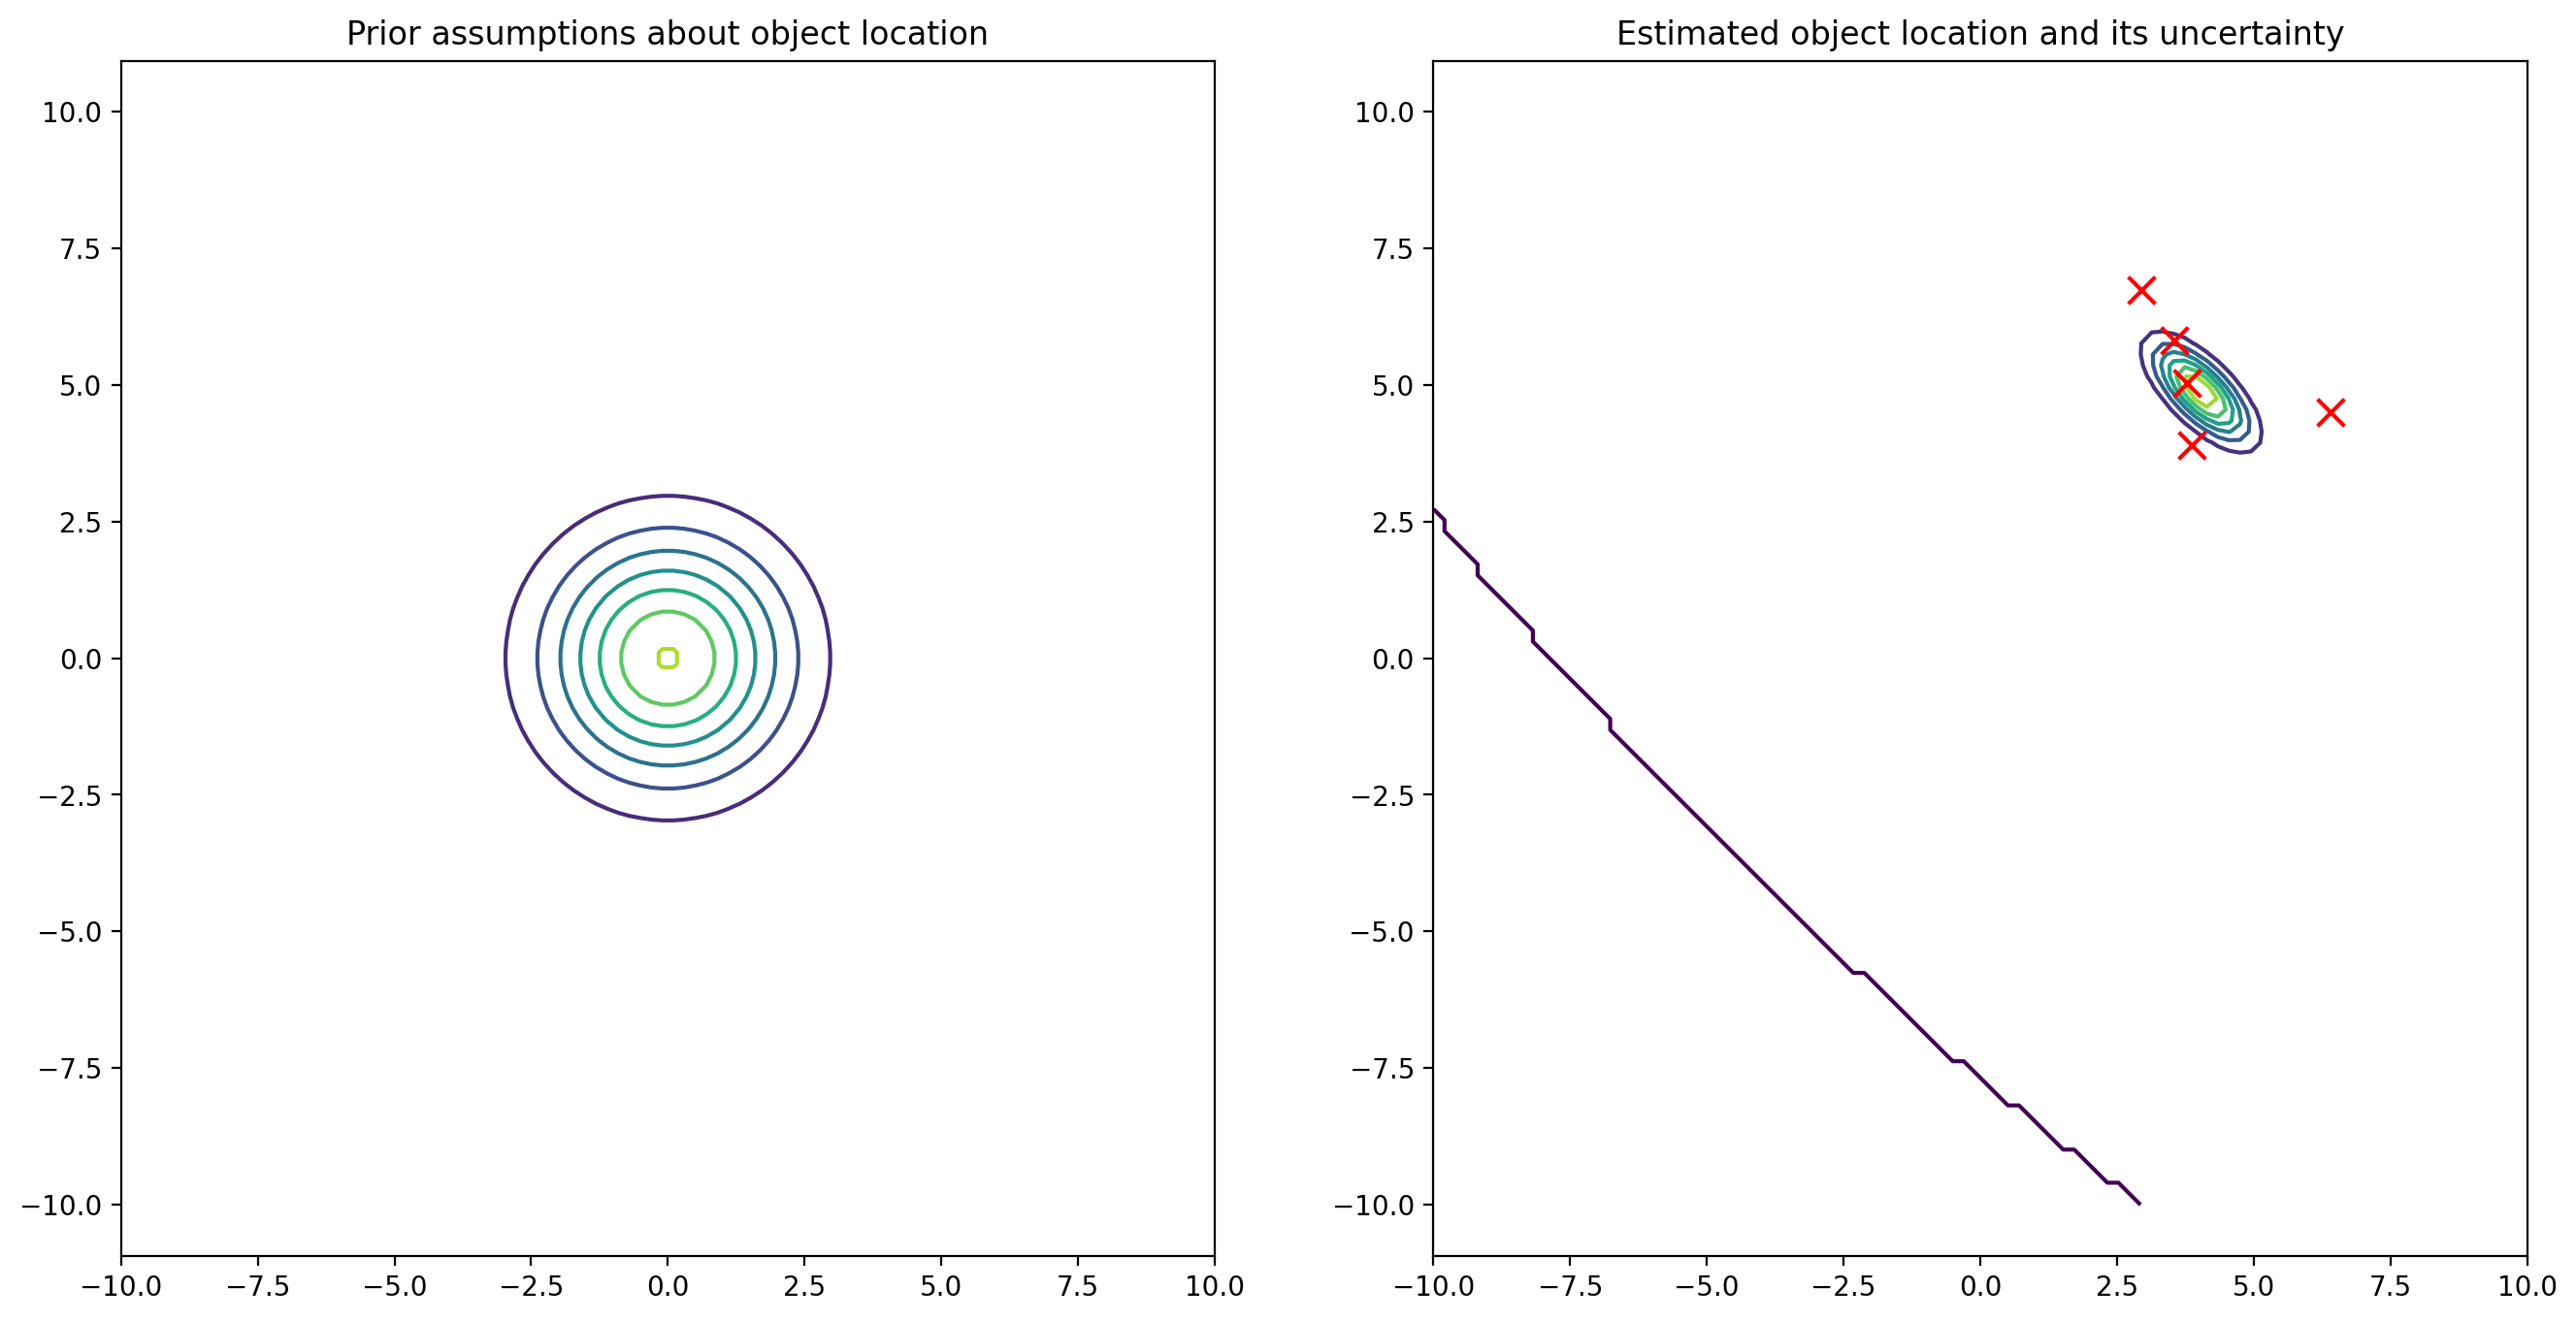

In [13]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

# raise Exception('Use estimate_location_from_echo_batch to estimate object location. '
#                 'Then plot the requested iso-density plots')

mu_xy, sigma_xy = estimate_location_from_echo_batch(radar_echo_n, radar_echo_Prec, sigma_x)
plot_mvn(ax[0], mu_x, sigma_x, None, "Prior assumptions about object location")
plot_mvn(ax[1], mu_xy, sigma_xy, radar_echo_n, "Estimated object location and its uncertainty")

### Verification of Estimations

The estimations from the iterative update procedure (`iterative_estimation`) and the batch update procedure (`estimate_location_from_echo_batch`) agree. Both methods yield the same estimated object location (`mu_xy`) and uncertainty (`sigma_xy`), confirming the correctness of the batch update equations.

### Derivation of the formulae and their proof

<div style="max-width:900px; margin: 0 auto; text-align: left;">
    
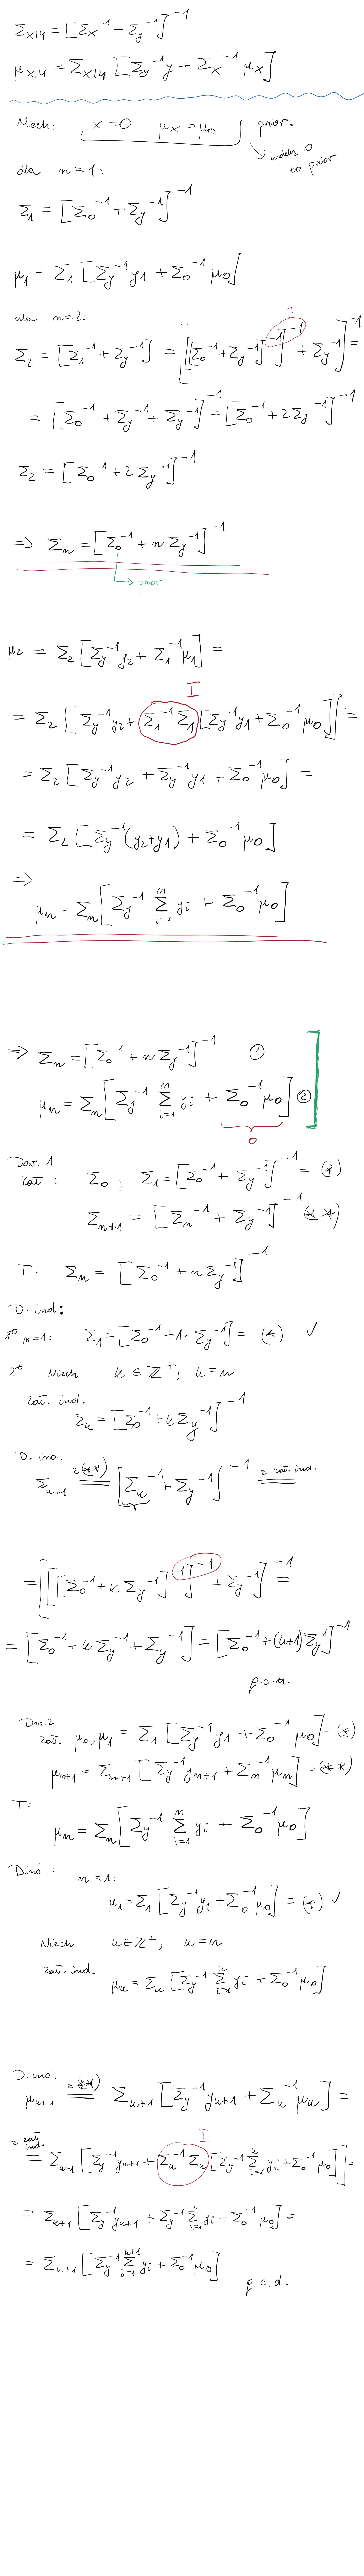
    
</div>
